In [1]:
!pip install psycopg2

In [2]:
import psycopg2 as ps
import psycopg2.extras as e
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import itertools as iter

In [3]:
PATH_SPLIT_DATA='C:\\Users\\Public\\CS645\\see_db_dataset\\splits'

# Piusha Gullapalli (pgullapalli@umass.edu)
def split_data(splits):
    data_raw = pd.read_csv(r'C:\\Users\\Public\\CS645\\see_db_dataset\\adult.txt')
    data_split = np.array_split(data_raw, splits)
    for k in range(1, len(data_split)+1):
        data_split[k-1].to_csv(os.path.join(PATH_SPLIT_DATA ,"split_{}.csv".format(k)),encoding='utf-8', index=False)

split_data(10)

In [4]:
# please run the sql file "load_tables.sql" on the postgreSQL

In [5]:
con = ps.connect("dbname='see_db' user='postgres' host='localhost' password='bluemoon0512'")
curs = con.cursor()

In [6]:
# dropping fnlwgt column

for table_name in ["split1", "split2", "split3", "split4", "split5", "split6", "split7", "split8", "split9", "split10"]:
    query_drop_fnlwgt = "ALTER TABLE {} DROP fnlwgt CASCADE;".format(table_name)
    curs.execute(query_drop_fnlwgt)
    con.commit()

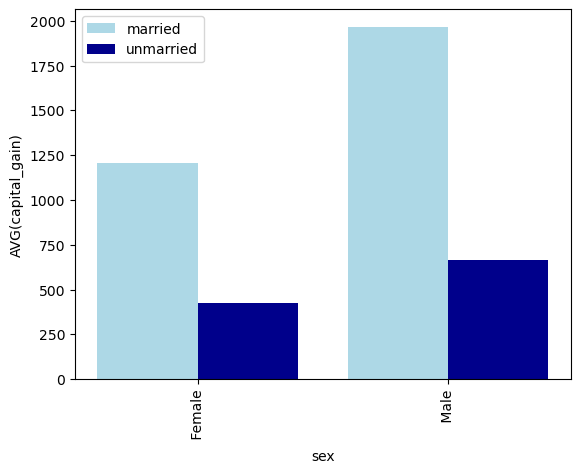

In [7]:
curs.execute("""create or replace view married as 
                   select * from census where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
           create or replace view unmarried as 
                   select * from census where marital_status in (' Never-married', ' Widowed',' Divorced');""")
con.commit()

curs.execute("select sex, avg(capital_gain) from married group by sex;")
target = curs.fetchall()

curs.execute("select sex, avg(capital_gain) from unmarried group by sex;")
reference = curs.fetchall()

# Piusha Gullapalli (pgullapalli@umass.edu)
# Apoorva Saraswat (apoorvasaras@umass.edu)
def create_plot(afm, reference, target):
    group_attr,function, measure = afm
    if group_attr == 'native_country':
        plt.rcParams["figure.figsize"]=(18.5,8)
    else:
        plt.rcParams.update(plt.rcParamsDefault)
    plt.subplots()
    graph1 = plt.bar(np.arange(len(target)), target.values(), 0.4, align='edge', linewidth=0.4, color = 'lightblue', label = 'married')
    graph2 = plt.bar(np.arange(len(target))+0.4, reference.values(), 0.4, align='edge', linewidth=0.4, color = 'darkblue', label = 'unmarried')

    plt.xlabel('{}'.format(group_attr))
    plt.ylabel('{}({})'.format(function, measure))
    plt.xticks(np.arange(len(target))+0.4, target.keys(), rotation=90)
    plt.legend()
    plt.show()

afm_plot = ('sex', 'AVG', 'capital_gain')
create_plot(afm_plot, dict(reference), dict(target))

In [8]:
# Piusha Gullapalli (pgullapalli@umass.edu)
def normalize(data):
    return data.reshape(-1)

#K-L divergence
def kl_divergence(ref_data, tar_data):
    ref_nor = normalize(ref_data)
    tar_nor = normalize(tar_data)
#     if sum(ref_nor) < 0 or sum(tar_nor) < 0:
#         return 0
    pro_ref = [i/np.sum(ref_nor) for i in ref_nor if sum(ref_nor)>0]
    pro_tar = [i/np.sum(tar_nor) for i in tar_nor if sum(tar_nor)>0]
    kl = np.sum([qi  * np.log(qi/pi) for qi, pi in zip(pro_tar, pro_ref) if pi>0 and qi>0])
    return kl

In [9]:
#phased execution

for i in range(10):
    curs.execute("""create or replace view split{}_married as 
                   select * from split{} where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
               create or replace view split{}_unmarried as 
                   select * from split{} where marital_status in (' Never-married', ' Widowed',' Divorced');""".format(i+1,i+1,i+1,i+1))
    con.commit()

In [10]:
funcs = ['sum', 'count', 'avg', 'min', 'max']
group_by_col = ["economic_indicator", "workclass", "occupation", "education", "race", "native_country", "sex", "relationship"]
measure_col = ["capital_loss", "capital_gain", "age", "hours_per_week"]

views = {pos:combo for pos, combo in enumerate(list(iter.product(funcs, measure_col, group_by_col)))}
tables = ['married', 'unmarried']

In [11]:
# Piusha Gullapalli (pgullapalli@umass.edu)
def share_based_optimization(tables, views, phase):
    print("in share_based_optimization")
    kl_dict={}
    for table in tables:
        for i, (f, m, a) in views.items():
            query="create or replace view vi_{} as select {}, {}({}) from split{}_{} group by {};".format(table+"_"+str(i),a,f,m,phase,table,a)
            curs.execute(query)
            con.commit()
            kl_dict[f+"-"+m+"-"+a]=["vi_"+str(table+"_"+str(i))]
    print("done")
    return kl_dict

In [21]:
# Apoorva Saraswat (apoorvasaras@umass.edu)
def get_views_scores(views, curs):
    views_scores = dict()

    for vid, (f, m, a) in views.items():
        tgt_sql_query = 'SELECT * FROM vi_unmarried_{}'.format(vid)
        curs.execute(tgt_sql_query)
        data = curs.fetchall()
        cols = [desc[0] for desc in curs.description]
        tgt_df = pd.DataFrame(data, columns=cols)


        ref_sql_query = 'SELECT * FROM vi_married_{}'.format(vid)
        curs.execute(ref_sql_query)
        data = curs.fetchall()
        cols = [desc[0] for desc in curs.description]
        ref_df = pd.DataFrame(data, columns=cols)

        temp_df = tgt_df.join(ref_df.set_index(a), on=a, how='inner', lsuffix='_target', rsuffix='_reference')
        

        tgt_val = temp_df['{}_target'.format(f)].values
        ref_val = temp_df['{}_reference'.format(f)].values

        score = kl_divergence(tgt_val, ref_val)
        views_scores[vid] = score
    return views_scores


In [13]:
# Apoorva Saraswat (apoorvasaras@umass.edu)
def pruning(views, i):
    delta = 0.05
    N = 10
    K = 5
    m = i+1
    views_to_be_deleted = list()
    
    print("Pruning for phase = " + str(i))
    
    if m == 1:
        # no views to compare to in first phase
        return views

    epsilon = np.sqrt((0.5/m)*(1-((m-1)/N))*(2*np.log(np.log(m))+np.log((np.pi**2)/(3*delta))))
    current_scores = get_views_scores(views, curs)
    sorted_scores = {k: v for k, v in sorted(current_scores.items(), key=lambda x: x[1], reverse=True)}        
    lower_bound = np.mean(list(sorted_scores.values())[K]) - epsilon
    
    for k, v in sorted_scores.items():
        higher_bound = np.mean(v) + epsilon
        if  higher_bound < lower_bound:
            print("deleting view " + str(k))
            views_to_be_deleted.append(k)

    for index in views_to_be_deleted:
        del views[index]

    return views

In [14]:
current_views = views
for i in range(10):
    kl_dicts = share_based_optimization(tables, current_views, i+1)
    pruning(current_views, i+1)

in share_based_optimization
done
Pruning for phase = 1
running get view scores...
done
in share_based_optimization
done
Pruning for phase = 2
running get view scores...
done
in share_based_optimization
done
Pruning for phase = 3
running get view scores...
done
in share_based_optimization
done
Pruning for phase = 4
running get view scores...
done
in share_based_optimization
done
Pruning for phase = 5
running get view scores...
done
in share_based_optimization
done
Pruning for phase = 6
running get view scores...
done
in share_based_optimization
done
Pruning for phase = 7
running get view scores...
done
deleting view 10
deleting view 136
deleting view 124
deleting view 142
deleting view 12
deleting view 122
deleting view 127
deleting view 130
deleting view 125
deleting view 39
deleting view 47
deleting view 55
deleting view 63
deleting view 65
deleting view 1
deleting view 31
deleting view 34
deleting view 42
deleting view 50
deleting view 58
deleting view 18
deleting view 26
deleting vi

In [23]:
# get top 5 views
current_scores = get_views_scores(current_views, curs)
top_views = {k: v for k, v in sorted(current_scores.items(), key=lambda item: item[1], reverse=True)[:5]}
print('Top views - \n')
for tp in top_views:
    print(current_views[tp])

Top views - 

('max', 'capital_loss', 'relationship')
('avg', 'capital_loss', 'relationship')
('max', 'capital_gain', 'native_country')
('sum', 'capital_loss', 'sex')
('sum', 'capital_loss', 'relationship')


In [16]:
# Apoorva Saraswat (apoorvasaras@umass.edu)
def print_top_views(top_views):
    for tp in top_views:
        f, m, a = current_views[tp]
            
        query = "SELECT {}, {}({}) FROM married WHERE trim({}) != 'NULL' GROUP BY {};".format(a, f, m, a, a)
        curs.execute(query)
        target_table = curs.fetchall()
        
        query = "SELECT {}, {}({}) FROM unmarried WHERE trim({}) != 'NULL' GROUP BY {};".format(a, f, m, a, a)
        curs.execute(query)
        reference_table = curs.fetchall()
        
        tgt_dict = dict(target_table)
        ref_dict = dict(reference_table)

        for k in tgt_dict.keys():
            if k not in ref_dict:
                ref_dict[k] = 0

        for k in ref_dict.keys():
            if k not in tgt_dict:
                tgt_dict[k] = 0
        
        create_plot((a,f,m), ref_dict, tgt_dict)

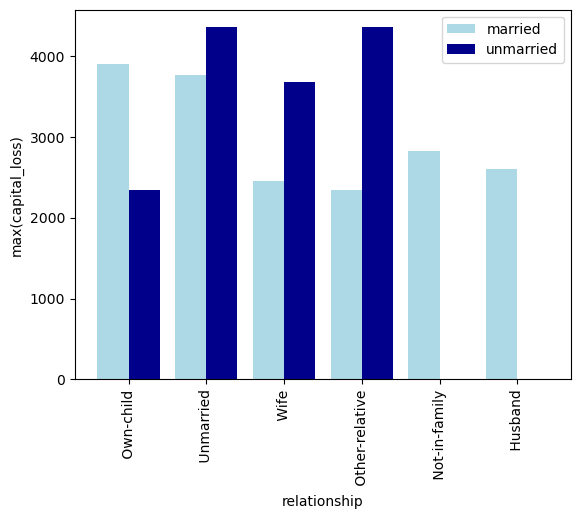

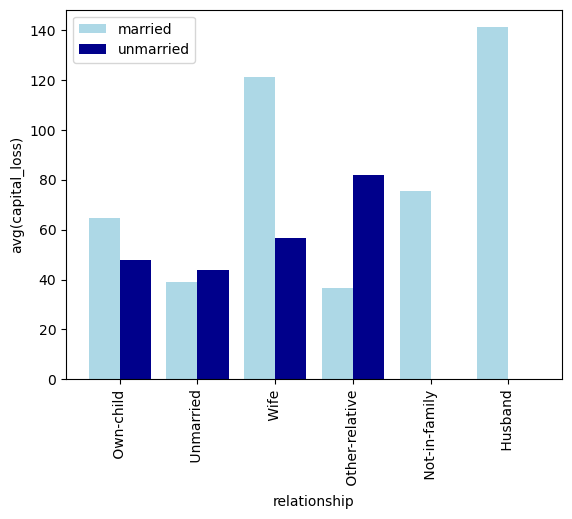

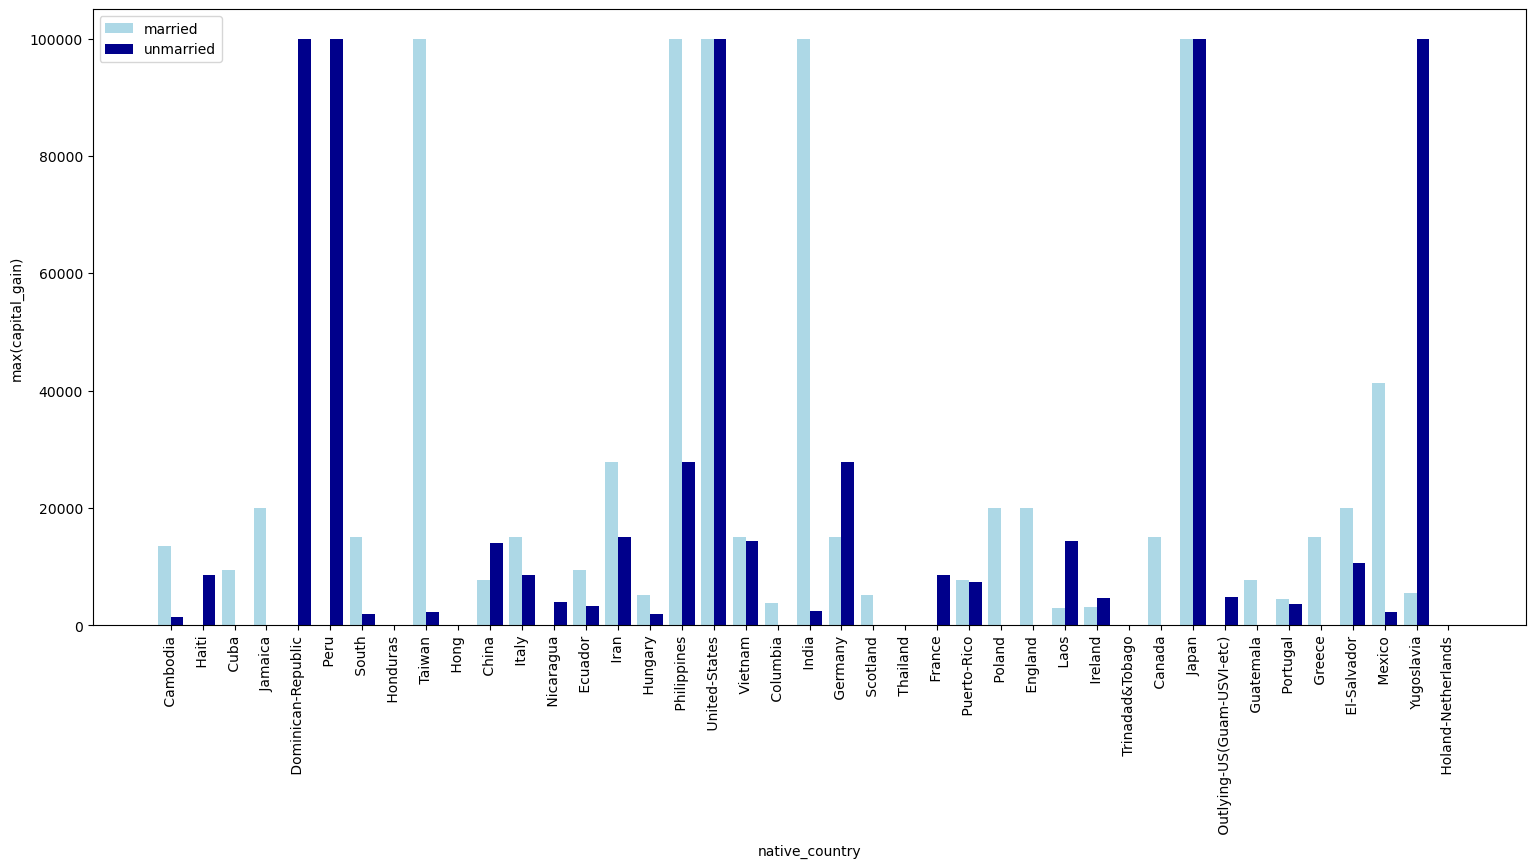

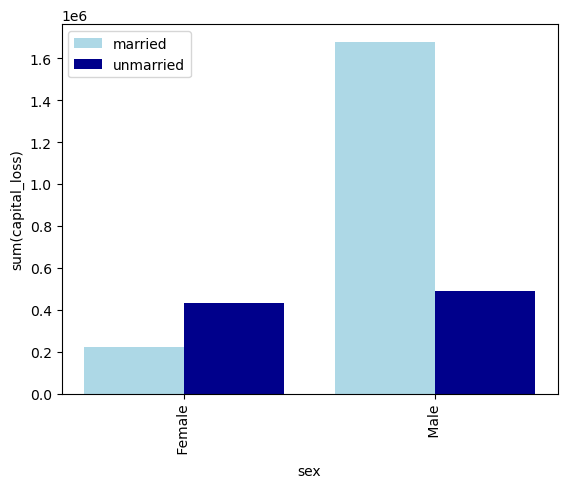

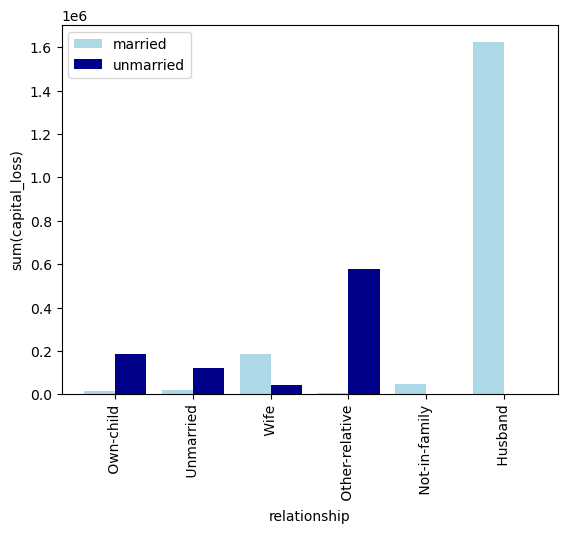

In [17]:
print_top_views(top_views)